In [180]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from scipy.integrate import cumulative_trapezoid
import scipy.optimize as optimize

import src.astrocal.cpi as cpi

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [17]:
main = "C:/Users/aurel/Desktop/DUAO Projet/(6) Hebe"

In [41]:
data_files = glob.glob(f"{main}/*.ecsv")
datas = {}
for file in data_files:
    name = file.replace('\\','/').split('/')[-1].replace('.ecsv','').replace('tempo-photo_','')
    data = ascii.read(file, format='ecsv')
    long_time = [len(data['mjd'][i])>50 for i in range(len(data))]
    abs_pm = np.linalg.norm(np.array([data['p_ra'], data['p_dec']]).T, axis=1)
    target = np.ma.argmax(np.ma.array(abs_pm, mask=np.logical_not(long_time)))
    row = data[target]
    print(name)
    print(f"dα = {row['p_ra']:.2f}\"/s")
    print(f"dδ = {row['p_dec']:.2f}\"/s")
    datas[name] = pd.DataFrame(data=np.array([row['mjd'], row['ins_mag'], row['app_mag'], row['airmass'], row['rel_flux']]).T,
                               columns=['mjd', 'ins_mag', 'app_mag', 'airmass', 'rel_flux'])
names = list(datas.keys())
print(names)

20240531_SDSSgp+
dα = -18.13"/s
dδ = -5.99"/s
20240531_SDSSip+
dα = -17.85"/s
dδ = -5.92"/s
20240531_SDSSrp+
dα = -18.16"/s
dδ = -6.03"/s
20240605_SDSSgp+
dα = -13.84"/s
dδ = -8.34"/s
20240605_SDSSip+
dα = -14.02"/s
dδ = -8.35"/s
20240605_SDSSrp+
dα = -13.98"/s
dδ = -8.49"/s
['20240531_SDSSgp+', '20240531_SDSSip+', '20240531_SDSSrp+', '20240605_SDSSgp+', '20240605_SDSSip+', '20240605_SDSSrp+']


In [42]:
print(datas[names[0]].keys())

Index(['mjd', 'ins_mag', 'app_mag', 'airmass', 'rel_flux'], dtype='object')


In [148]:
phase = 7.2745
JD_0 = 0.1
for name in names:
    data = datas[name]
    data['phase'] = ((data['mjd']-JD_0)*(24/phase)*360)%360
    offset = -0.06 if "20240605" in name else 0
    data['normalized'] = data['rel_flux'] + offset
    ZP = np.nanmedian(data['app_mag'] - data['ins_mag']*data['airmass'])
    data['app_mag_corr'] = data['ins_mag']*data['airmass'] + ZP + offset

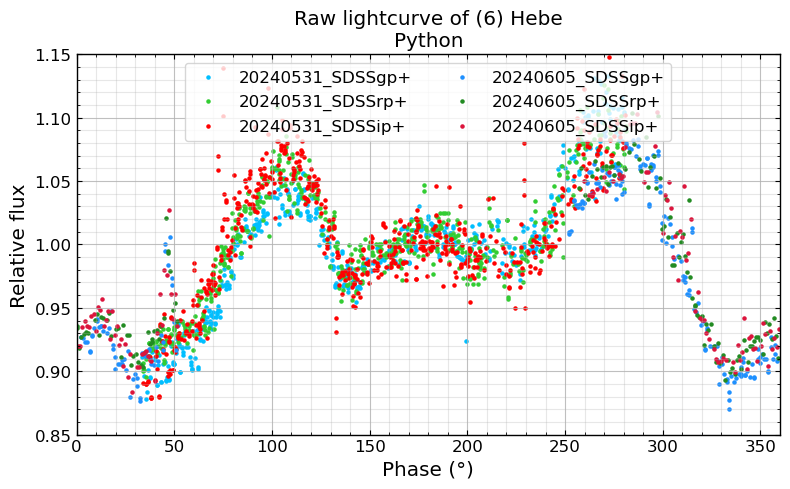

In [149]:
colors = {'20240531_SDSSgp+': 'deepskyblue',
         '20240531_SDSSrp+': 'limegreen',
         '20240531_SDSSip+': 'red',
         '20240605_SDSSgp+': 'dodgerblue',
         '20240605_SDSSrp+': 'forestgreen',
         '20240605_SDSSip+': 'crimson',}

fig, ax = plt.subplots(figsize=(8,5))
for name in colors:
    data = datas[name]
    ax.scatter(data['phase'], data['normalized'], color=colors[name], s=5, label=name, rasterized=True)
ax.set_xlim(0, 360)
ax.set_ylim(0.85,1.15)
ax.legend(loc='upper center', ncols=2)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Relative flux")
ax.set_title("Raw lightcurve of (6) Hebe\nPython")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

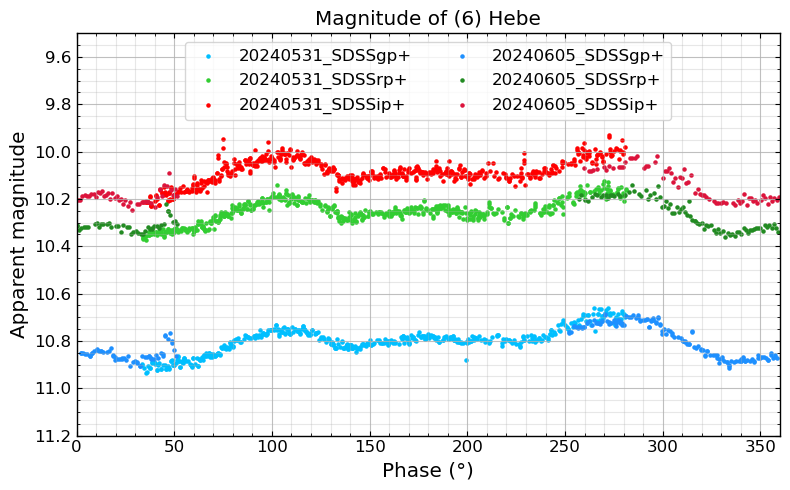

In [150]:
colors = {'20240531_SDSSgp+': 'deepskyblue',
         '20240531_SDSSrp+': 'limegreen',
         '20240531_SDSSip+': 'red',
         '20240605_SDSSgp+': 'dodgerblue',
         '20240605_SDSSrp+': 'forestgreen',
         '20240605_SDSSip+': 'crimson',}

fig, ax = plt.subplots(figsize=(8,5))
for name in colors:
    data = datas[name]
    ax.scatter(data['phase'], data['app_mag_corr'], color=colors[name], s=5, label=name, rasterized=True)
ax.set_xlim(0, 360)
ax.set_ylim(9.5, 11.2)
ax.legend(loc='upper center', ncols=2)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Apparent magnitude")
ax.set_title("Magnitude of (6) Hebe")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Magnitude_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Magnitude_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

In [155]:
phase = np.arange(0,360,1)
window = 20
analysed_data = {}
for filter in ['gp', 'rp', 'ip']:
    tables = [datas[name][['phase', 'normalized', 'app_mag_corr']] for name in names if filter in name]
    concat = pd.concat(tables)
    normalized = []
    mag = []
    for p in phase:
        start, end = p-0.5*window, p+0.5*window
        if (start<0) & (end>360):
            sel = True
        elif start<0:
            sel = (concat['phase']>=start%360)|(concat['phase']<end)
        elif end>360:
            sel = (concat['phase']>=start)|(concat['phase']<end%360)
        else:
            sel = (concat['phase']>=start)&(concat['phase']<end)
        normalized.append(sigma_clipped_stats(concat['normalized'][sel], sigma=3.0)[0])
        mag.append(sigma_clipped_stats(concat['app_mag_corr'][sel], sigma=3.0)[0])
    analysed_data[filter] = pd.DataFrame(np.array([phase, normalized, mag]).T, columns=['phase', 'normalized_avg', 'app_mag_avg'])
    
for filter in analysed_data:
    print(f"{filter} : {len(analysed_data[filter])}")

gp : 360
rp : 360
ip : 360


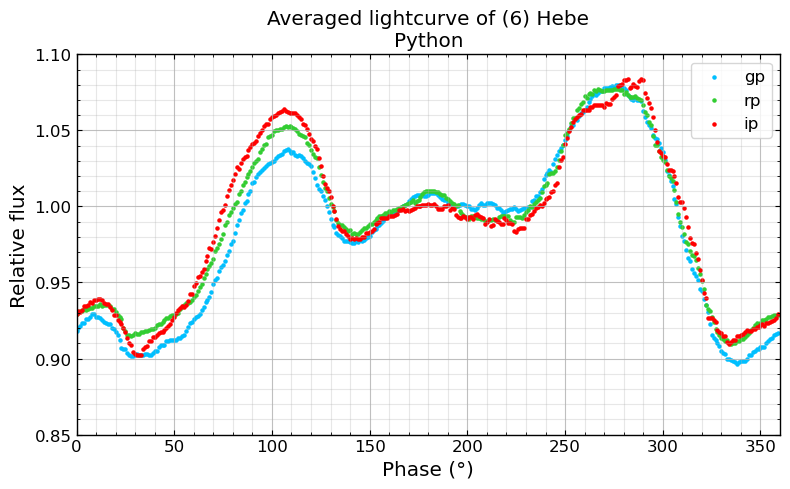

In [157]:
colors = {'gp': 'deepskyblue',
         'rp': 'limegreen',
         'ip': 'red',}
fig, ax = plt.subplots(figsize=(8,5))
for filter in analysed_data:
    data = analysed_data[filter]
    ax.scatter(data['phase'], data['normalized_avg'], color=colors[filter], s=5, label=filter)
ax.set_xlim(0,360)
ax.set_ylim(0.85,1.1)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Relative flux")
ax.legend()
ax.set_title("Averaged lightcurve of (6) Hebe\nPython")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-avg_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-avg_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

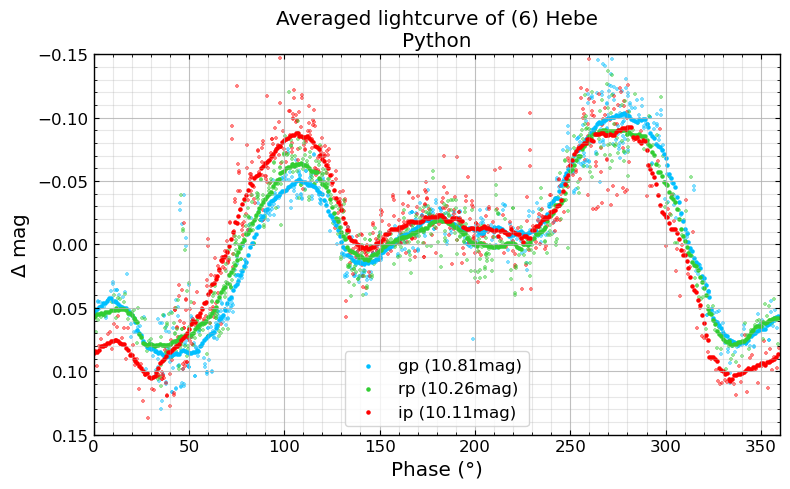

In [179]:
colors = {'gp': 'deepskyblue',
         'rp': 'limegreen',
         'ip': 'red',}
fig, ax = plt.subplots(figsize=(8,5))
for name in datas:
    data = datas[name]
    filter = name.split("_")[-1][4:-1]
    ax.scatter(data['phase'], data['app_mag_corr']-np.mean(analysed_data[filter]['app_mag_avg']), color=colors[filter], marker='+', s=10, alpha=0.5, rasterized=True)
for filter in analysed_data:
    data = analysed_data[filter]
    ax.scatter(data['phase'], data['app_mag_avg']-np.mean(data['app_mag_avg']), color=colors[filter], s=5, label=f"{filter} ({np.mean(data['app_mag_avg']):.2f}mag)")
ax.set_xlim(0,360)
ax.set_ylim(-0.15,0.15)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("$\Delta$ mag")
ax.legend(loc='lower center')
ax.set_title("Averaged lightcurve of (6) Hebe\nPython")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-mag-avg_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-mag-avg_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

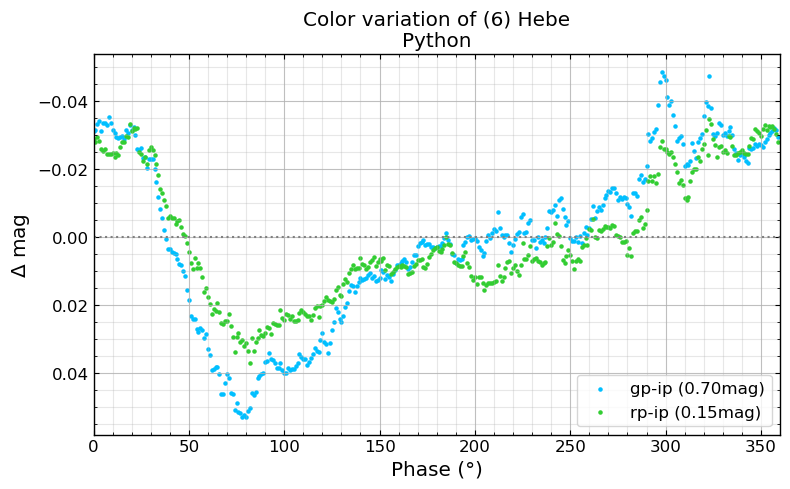

In [145]:
colors = {'gp': 'deepskyblue',
         'rp': 'limegreen',
         'ip': 'red',}
ref = 'ip'
fig, ax = plt.subplots(figsize=(8,5))
for filter in analysed_data:
    if filter != ref:
        data = analysed_data[filter]
        color = data['app_mag_avg']-analysed_data[ref]['app_mag_avg']
        ax.scatter(data['phase'], color - np.mean(color), color=colors[filter], s=5, label=f"{filter}-{ref} ({np.mean(color):.2f}mag)")
ax.axhline(0, c='gray', ls=':')
ax.set_xlim(0,360)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("$\Delta$ mag")
ax.legend(loc='lower right')
ax.set_title("Color variation of (6) Hebe\nPython")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Color_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Color_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [139]:
sun_angle = np.deg2rad(17)
psi = np.pi - sun_angle
theta, r_gp = cpi.light_curve2radius_cons(analysed_data['gp']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)
theta, r_rp = cpi.light_curve2radius_cons(analysed_data['rp']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)
theta, r_ip = cpi.light_curve2radius_cons(analysed_data['ip']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)

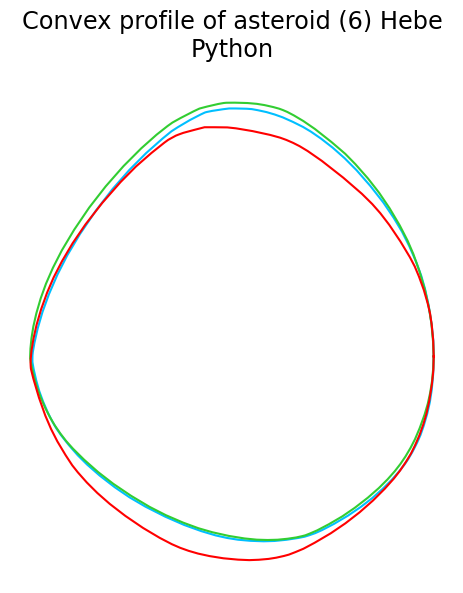

In [140]:
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("Convex profile of asteroid (6) Hebe\nPython")
cpi.plot_from_radius(r_gp, ax=ax, color='deepskyblue')
cpi.plot_from_radius(r_rp, ax=ax, color='limegreen')
cpi.plot_from_radius(r_ip, ax=ax, color='red')
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Convex-profile_Python.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Convex-profile_Python.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [223]:
d_BO = np.array([2.0939, 2.1371])*u.AU
d_BS = np.array([2.8637, 2.8593])*u.AU
phase = np.array([15.49, 16.58])*u.deg
G = 0.24

In [224]:
def phi(i, alpha):
    A = [3.332, 1.862]
    B = [0.631, 1.218]
    return np.exp(-A[i-1]*np.tan(0.5*alpha)**B[i-1])

def q(alpha, G):
    return (1-G)*phi(1,alpha) + G*phi(2,alpha)
q_phase = q(phase, G)

In [225]:
m_offset = - 5*np.log10(d_BS*d_BO/u.AU**2) + 2.5*np.log10(q_phase)
m_offset

<Quantity [-4.64469235, -4.71896382]>

In [226]:
m_g = np.array([10.81, 10.87])
m_r = np.array([10.26, 10.32])
m_i = np.array([10.11, 10.17])
H_g = m_g + m_offset
H_r = m_r + m_offset
H_i = m_i + m_offset
print(H_g, H_r, H_i)

[6.16530765 6.15103618] [5.61530765 5.60103618] [5.46530765 5.45103618]


In [227]:
albedo = 0.2679
def diameter(H, albedo):
    return 1329/np.sqrt(albedo) * 10**(-0.2*H) * u.km

In [231]:
D_g = diameter(H_g, albedo)
D_r = diameter(H_r, albedo)
D_i = diameter(H_i, albedo)

In [232]:
print(D_g, D_r, D_i)

[150.13332212 151.12328618] km [193.40918491 194.68450567] km [207.24167544 208.60820626] km


In [235]:
def gr_to_BV(gr):
    return 0.9814*gr + 0.2309
gr_to_BV(0.55)

0.7706700000000001